# Frequency-Accuracy Analysis

This notebook analyze the relationship between the frequency of the signal and the predicted accuracy of the hypnosis depth. This analysis is done response to the following reviewer's comment:

"The fact that higher frequency components contribute more to the prediction of the hypnosis depth suggest a more general relationship between hypnosis and the EEG spectrum. It would have been informative to plot a frequency – accuracy plot where frequency is divided in narrow frequency intervals with a logarithmic granularity from 1 Hz up to 60 Hz on the y-axis and prediction accuracy represented on the x-axis. The deviation of that curve would be interesting to analyze relative to the linear function. Would we see steps with the conventional delta, theta, alpha, beta and gamma bands?"

In [1]:
# imports
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import mne

# constants
epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif')
ch_names = epochs.ch_names.copy()  # make sure to copy the list because it is mutable in place
[ch_names.remove(i) for i in ['M1', 'M2', 'EOG1', 'EOG2', 'ECG']]
all_channels = epochs.ch_names
del epochs

# name of electrode groups
ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
 'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
 'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
 'LO': ['O1', 'PO3'],
 'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6',],
 'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
 'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
 'RO': ['O2', 'PO4'],
 'FZ': ['Fpz', 'Fz'],
 'CZ': ['Cz', 'FCz'],
 'PZ': ['Pz', 'CPz'],
 'OZ': ['POz', 'Oz', 'Iz'],
 'all': ch_names
}

# index of electrode groups
rois = {}
for k,v in ba_patches.items():
    temp = [all_channels.index(i) for i in v]
    rois[k] = temp

Reading /Users/yeganeh/Codes/SugNet/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated


## Feature extraction

### Power Sensor

In [3]:
# open power sensor
with open(f'docs/psds_3th_higher_frequency_resolution.pkl', 'rb') as f:
    psds = pkl.load(f)

def constant_q_bins(fmin=1.0, fmax=42.0, bins_per_oct=6):
    centers = []
    f = fmin
    while f <= fmax:
        f *= 2**(1/bins_per_oct)
        centers.append(f)
    centers = np.array(centers)
    width = 2**(1/(2*bins_per_oct))
    edges = np.column_stack([centers/width, centers*width])
    edges[:, 0] = np.maximum(edges[:, 0], fmin)
    edges[:, 1] = np.minimum(edges[:, 1], fmax)
    return centers, edges  # (n_bins,), (n_bins,2)

freqs = psds.pop('freqs')

In [ ]:
roi_features_all = {}
DB = False
RELATIVE = False
for key in psds.keys():

    # Interpolate PSD onto dense frequency grid
    psd = psds[key]  # (n_channels, n_freqs)
    freq_dense = np.arange(1, 42, 0.02)
    psd_dense = np.array([np.interp(freq_dense, freqs, psd[i]) for i in range(psd.shape[0])])

    centers, edges = constant_q_bins(1.0, 42.0, bins_per_oct=6)

    # 1) Bin power per channel (physical approach)
    bin_vals = []
    for f1, f2 in edges:
        m = (freq_dense >= f1) & (freq_dense <= f2)
        # integrate linear PSD then divide by bandwidth
        bw = (f2 - f1)
        # trapezoidal integral per channel
        p_lin = np.trapezoid(psd_dense[:, m], freq_dense[m], axis=1) / bw
        if DB:
            p_db  = 10*np.log10(p_lin + 1e-20)  # (n_channels,)
        bin_vals.append(p_lin)
    bin_vals = np.stack(bin_vals, axis=1)  # (n_channels, n_bins)

    # 2) ROI average in dB
    roi_features = []
    for roi_name, ch_idx in rois.items():
        roi_features.append(np.nanmean(bin_vals[ch_idx, :], axis=0))  # (n_bins,)
    roi_features = np.stack(roi_features, axis=1)  # (n_bins, n_rois)

    # # 3) convert to relative power across bins (per ROI)
    if RELATIVE:
        roi_features = (roi_features - roi_features.mean(axis=0, keepdims=True)) / roi_features.std(axis=0, keepdims=True)

    roi_features_all[key] = roi_features

## Classification

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API") # Supress dependancies warning till new sklearn versions is released

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [32]:
max_acc = {}
for freq_bin in range(33):
    print(f'>>> {freq_bin}')
    df = pd.DataFrame([])
    for key in roi_features_all.keys():
        df = pd.concat([df, pd.DataFrame(roi_features_all[key][freq_bin], columns=[key], index=list(rois.keys())).T], axis=0)

    df.reset_index(inplace=True)
    df[['bids_id', 'condition']] = df['index'].apply(lambda x: x.split('_')).apply(pd.Series)
    df.drop(columns='index', inplace=True)
    df['session'] = df['condition'].apply(lambda x: x[-1])

    # open session data and merge with power values
    session_data = pd.read_csv('data/behavioral_data/archived/behavioral_data.csv')
    df = df.astype({'session': 'int64'})
    df = pd.merge(session_data, df, how='right', on=['session', 'bids_id'], right_index=False)
    df.insert(1, 'condition', df.pop('condition'))

    # DATA
    df_cls = df.query('description == "hypnosis"').reset_index(drop=True)
    X = df_cls[list(rois.keys())].values
    y = df_cls['hypnosis_depth'].apply(lambda x: 0 if x<=5 else 1).values
    groups = df_cls['bids_id'].values

    # MODEL
    pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('cls', SVC(max_iter=10000000, kernel='linear', class_weight='balanced'))
        ])

    CV = GroupShuffleSplit(50, test_size=0.2)

    grid_params = [{
        'cls__C': [0.1, 0.5, 1, 5, 10, 50, 100],
    }]

    grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1, n_jobs=-1)
    grid.fit(X, y, groups=groups)

    grid_results = pd.DataFrame(grid.cv_results_)

    best_C_idx = grid_results['mean_test_score'].idxmax()
    acc_cols = [c for c in grid_results if 'split' in c]
    acc_cols.append('mean_test_score')

    accuracies = grid_results.loc[best_C_idx, acc_cols]
    max_acc[freq_bin] = accuracies

acc_df = pd.DataFrame.from_dict(max_acc, orient='index')
acc_mean = acc_df['mean_test_score']

# find min and max split accuracies in each row
min_acc = acc_df.filter(like='split').min(axis=1)
max_acc = acc_df.filter(like='split').max(axis=1)

acc_ci = pd.concat([min_acc, max_acc], axis=1).rename(columns={0: 'min',
                                                               1: 'max'})

>>> 0
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 1
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 2
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 3
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 4
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 5
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 6
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 7
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 8
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 9
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 10
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 11
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 12
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 13
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 14
Fitting 50 folds for each of 7 candid

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Power · Sensor'}, xlabel='Balanced accuracy', ylabel='Frequency (Hz, log scale)'>)

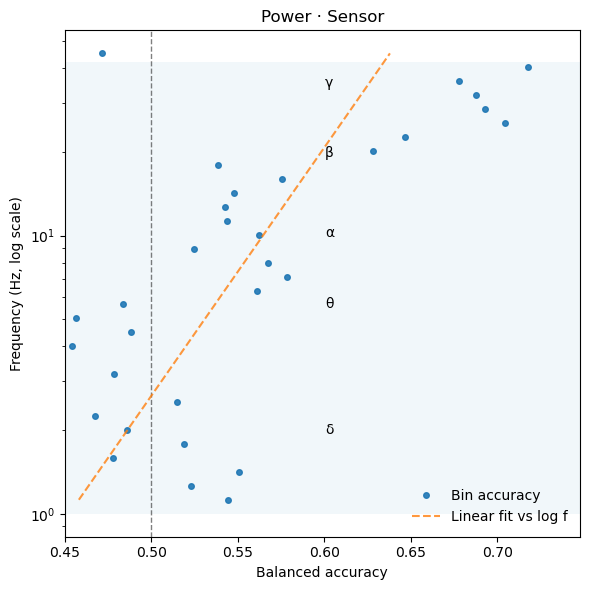

In [ ]:
def plot_freq_accuracy(freq_centers, acc_mean, acc_ci=None, title="Power · Sensor"):
    """
    freq_centers: (n_bins,) in Hz
    acc_mean:     (n_bins,) accuracy or balanced accuracy
    acc_ci:       (n_bins,2) lower/upper CI (optional)
    """
    f = np.array(freq_centers, float)
    a = np.array(acc_mean, float)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_yscale('log')

    # canonical bands (adjust to your limits)
    bands = [
        ("δ", 1, 4), ("θ", 4, 8), ("α", 8, 13),
        ("β", 13, 30), ("γ", 30, 42)
    ]
    for label, lo, hi in bands:
        ax.axhspan(lo, hi, alpha=0.06)  # gentle shading
        ax.text(0.505, (lo*hi)**0.5, label, va='center', ha='left', transform=ax.get_yaxis_transform())

    # points + horizontal error bars
    if acc_ci is not None:
        lo = acc_ci.loc[:, 'min']
        hi = acc_ci.loc[:, 'max']
        xerr = np.vstack([a - lo, hi - a])
        ax.errorbar(a, f, xerr=xerr, fmt='o', ms=4, capsize=2, alpha=0.9, label='Bin accuracy')
    else:
        ax.plot(a, f, 'o', ms=4, alpha=0.9, label='Bin accuracy')

    # chance & optional null band
    ax.axvline(0.5, ls='--', lw=1, alpha=0.5, color='k')   # chance for balanced acc
    # ax.axvspan(0.48, 0.52, color='k', alpha=0.05)        # null band from shuffles (if you have it)

    # linear trend vs log-frequency
    X = np.vstack([np.ones_like(f), np.log(f)]).T
    beta = np.linalg.lstsq(X, a, rcond=None)[0]
    a_hat = X @ beta
    ax.plot(a_hat, f, ls='--', lw=1.5, alpha=0.8, label='Linear fit vs log f')

    ax.set_xlabel('Balanced accuracy')
    ax.set_ylabel('Frequency (Hz, log scale)')
    ax.set_title(title)
    ax.set_xlim(max(0.45, a.min()-0.03), min(1.0, a.max()+0.03))
    ax.legend(loc='lower right', frameon=False)
    plt.tight_layout()
    return fig, ax

plot_freq_accuracy(centers, acc_mean)


In [ ]:
## why would we observe such a trend when not using non decibel transformed data? does it have to do with the 1/f??

# Gamma Coherency Analysis

This analysis is done in response to the following comment:

**I was missing a focus on analyzing the widespread gamma coherence across distant brain regions. The coherence of gamma is expected to decrease between regions as consciousness disintegrates. Under altered states of consciousness, such as observed in anesthesia ad or other drug induced states, gamma breaks down to local islands of coherent oscillation nodes over the cerebral cortex while distant regions decohere. Was that network dynamics analyzed but did not yield any difference in network coherence or this was disregarded for other reasons?**

In [3]:
epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif')
conn = pd.read_csv('data/classification_datasets/wpli_sensor.csv', index_col=0)

gamma_cols = [c for c in conn.columns if 'gamma' in c]
FCz_cols = [c for c in conn.columns if 'FCz' in c]
gamma_cols = [c for c in gamma_cols if c not in FCz_cols] # remove those FCz columns because of the missing channel position

conn = conn.query('condition.str.contains("experience")')
conn = conn.query('description == "hypnosis"')
conn['depth_class'] = conn['hypnosis_depth'].apply(lambda x: 0 if x<= 5 else 1)

# only include gamma columns
conn_dp = conn.query('depth_class == 1')[gamma_cols].values
conn_sh = conn.query('depth_class == 0')[gamma_cols].values

Reading /Users/yeganeh/Codes/SugNet/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated


In [13]:
ch_names = epochs.ch_names.copy()  # make sure to copy the list because it is mutable in place
[ch_names.remove(i) for i in ['M1', 'M2', 'EOG1', 'EOG2', 'ECG', 'FCz']] # remove FCz that's with no pos coordiantes 
ch_idx = [all_channels.index(ch) for ch in ch_names]  # EEG channel indices (other channels removed)
pos = np.array([epochs.info['chs'][i]['loc'][:3] for i in ch_idx])
D = np.linalg.norm(pos[:, None,:]-pos[None,:,:], axis=2)
triu = np.triu_indices_from(D, k=1)
d = D[triu]

q30, q70 = np.quantile(d, [0.3, 0.7])
short_idx = d <= q30; long_idx = d >= q70

metrics = {
    'short_mean_shallow': conn_sh[:, short_idx].mean(),
    'short_mean_deep':    conn_dp[:, short_idx].mean(),
    'long_mean_shallow':  conn_sh[:, long_idx].mean(),
    'long_mean_deep':     conn_dp[:, long_idx].mean(),
    # 'slope_shallow': np.polyfit(d, conn_sh, 1)[0],
    # 'slope_deep':    np.polyfit(d, conn_dp, 1)[0],
}

### ROI MNI Centroids

In [ ]:
import re
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

In [ ]:
subject = 'fsaverage'
subjects_dir = 'data/'
atlas_labels = mne.read_labels_from_annot(subject,
                                          'Yeo2011_7Networks_N1000',
                                          subjects_dir= subjects_dir)

# src = mne.setup_source_space(subject, spacing='ico5', subjects_dir=subjects_dir, add_dist=False, verbose=False)
roi_xyz = []
roi_names = []
roi_hemi = []
for lab in atlas_labels:
    # returns a vertex id on that hemi
    vert = int(lab.center_of_mass(subject=subject, subjects_dir=subjects_dir))
    # convert vertex to MNI xyz
    mni = mne.vertex_to_mni(vertices=[vert], hemis=[0 if lab.hemi=='lh' else 1],
                            subject=subject, subjects_dir=subjects_dir)[0]
    m = re.search('7Networks_([A-Za-z0-9]+)-(.+)', lab.name)
    roi_xyz.append(mni)
    roi_names.append(yeo7[f'N{m.group(1)}'] + f'_{m.group(2)}' if m else 'Medial_Wall')
    roi_hemi.append('L' if lab.hemi=='lh' else 'R')
roi_xyz = np.array(roi_xyz)  # shape (16, 3)

# not the best practice but here manually adding the hemispheres' info to the last two names for congruency with FC labels
roi_names[-2] = roi_names[-2] + '_lh'
roi_names[-1] = roi_names[-1] + '_rh'

Reading labels from parcellation...
   read 8 labels from /Users/yeganeh/Codes/SugNet/data/fsaverage/label/lh.Yeo2011_7Networks_N1000.annot
   read 8 labels from /Users/yeganeh/Codes/SugNet/data/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot
